- 데이터 전처리를 위한 코드입니다. (10.29)
- 경기 미달 선수 제거 코드 추가 (11.01)
- 포지션별 데이터 생성 (11.02)
- 시즌별 승점 변수 추가 (11.08)
- 선수 이름 오류 해결 (11.09)
- 이상치 제거 (연봉==0) (11.09)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 라이브러리 불러오기

In [2]:
import re
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# 그래프 한글화

In [ ]:
# 실행 후 런타임 재시작 필요
!apt install fonts-nanum-coding  # 가독성이 좋은 나눔고딕코딩 선정
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum-coding
0 upgraded, 1 newly installed, 0 to remove and 4 not upgraded.
Need to get 1,083 kB of archives.
After this operation, 4,610 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum-coding all 2.5-1 [1,083 kB]
Fetched 1,083 kB in 1s (1,426 kB/s)
Selecting previously unselected package fonts-nanum-coding.
(Reading database ... 123942 files and directories currently installed.)
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/

In [ ]:
# 설치된 폰트 확인
for f in fm.get_fontconfig_fonts():
    if 'Nanum' in f:
        print(f)

/usr/share/fonts/truetype/nanum/NanumGothicCoding-Bold.ttf
/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf


In [ ]:
# matplotlib 설정
plt.rcParams['figure.figsize'] = (14, 4)
plt.rcParams['font.size'] = 13
font_location = '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)

# 데이터셋 불러오기

In [52]:
data_path = '/content/drive/MyDrive/Colab Notebooks/캡스톤_4조/dataset/'
salary_data = pd.read_csv(data_path + 'salary_data.csv')
salary_data = salary_data.drop(columns= ['Unnamed: 0'])
salary_data = salary_data.astype({'Year':'str'})
salary_data['Code'] = salary_data['Team'].str[:4] + salary_data['Player'].str[-6:] + salary_data['Year'].str[2:]

salary_data.info()
salary_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6071 entries, 0 to 6070
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Player           6071 non-null   object
 1   Salary (€/year)  6071 non-null   int64 
 2   Position         6071 non-null   object
 3   Year             6071 non-null   object
 4   Team             6071 non-null   object
 5   League           6071 non-null   object
 6   Code             6071 non-null   object
dtypes: int64(1), object(6)
memory usage: 332.1+ KB


,Player,Salary (€/year),Position,Year,Team,League,Code
0,João Moutinho,5992270,M,2022,wolverhampton,Premier League,wolvutinho22
1,Matheus Nunes,5093430,M,2022,wolverhampton,Premier League,wolv Nunes22
2,Nélson Semedo,4609439,D,2022,wolverhampton,Premier League,wolvSemedo22
3,Daniel Podence,3595362,F,2022,wolverhampton,Premier League,wolvodence22
4,Pedro Neto,2996135,F,2022,wolverhampton,Premier League,wolvo Neto22
...,...,...,...,...,...,...,...
6066,Nacho Monreal,0,D,2014,arsenal,Premier League,arseonreal14
6067,Ignasi Miquel,0,D,2014,arsenal,Premier League,arseMiquel14
6068,Wellington Silva,0,F,2014,arsenal,Premier League,arse Silva14
6069,Joel Campbell,0,F,2014,arsenal,Premier League,arsempbell14


In [53]:
data_list = []
premier_league = pd.DataFrame()

for year in range(2014,2023):
    path = data_path + 'england-premier-league-players-{}-to-{}-stats.csv'.format(year, year+1)
    data_list.append(path)

for file in data_list:
    data = pd.read_csv(file)
    premier_league = pd.concat([premier_league, data], ignore_index=True)

premier_league['season'] = premier_league['season'].str[:4]
#premier_league.rename(columns={'full_name':'Player', 'season':'Year'}, inplace=True)
premier_league['Current Club'] = premier_league['Current Club'].str.lower()
premier_league['Current Club'] = premier_league['Current Club'].str.replace(" ", "")

premier_league['Code'] = premier_league['Current Club'].str[:4] + premier_league['full_name'].str[-6:] + premier_league['season'].str[2:]

premier_league

,full_name,age,birthday,birthday_GMT,league,season,position,Current Club,minutes_played_overall,minutes_played_home,...,min_per_conceded_overall,min_per_match,min_per_card_overall,min_per_assist_overall,cards_per_90_overall,rank_in_league_top_attackers,rank_in_league_top_midfielders,rank_in_league_top_defenders,rank_in_club_top_scorer,Code
0,Aaron Cresswell,32,629712000,1989/12/15,Premier League,2014,Defender,westhamunited,3420,1710,...,81,90,684,855,0.13,205,130,63,8,westsswell14
1,Aaron Lennon,35,545554800,1987/04/16,Premier League,2014,Midfielder,everton,1347,655,...,84,59,449,674,0.20,129,101,-1,7,everLennon14
2,Aaron Mitchell,26,829465200,1996/04/14,Premier League,2014,Midfielder,queensparkrangers,0,0,...,0,0,0,0,0.00,-1,-1,-1,-1,queetchell14
3,Aaron Ramsey,31,662198400,1990/12/26,Premier League,2014,Midfielder,arsenal,2009,975,...,112,69,335,335,0.27,60,28,-1,4,arseRamsey14
4,Abel Mathías Hernández Platero,32,650098800,1990/08/08,Premier League,2014,Forward,hullcity,1312,861,...,77,52,656,1312,0.14,61,172,-1,3,hulllatero14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5371,Yerson Mosquera Valdelamar,21,988786800,2001/05/02,Premier League,2022,Midfielder,wolverhamptonwanderers,0,0,...,0,0,0,0,0.00,-1,-1,-1,-1,wolvelamar22
5372,Yoane Wissa,26,841734000,1996/09/03,Premier League,2022,Forward,brentford,312,106,...,62,39,312,312,0.29,13,30,-1,2,bren Wissa22
5373,Youri Tielemans,25,862988400,1997/05/07,Premier League,2022,Midfielder,leicestercity,585,271,...,29,73,0,585,0.00,76,67,-1,6,leiclemans22
5374,Yves Bissouma,26,841388400,1996/08/30,Premier League,2022,Midfielder,tottenhamhotspur,155,28,...,155,22,78,0,1.16,-1,-1,-1,14,tottssouma22


In [54]:
df = pd.merge(salary_data, premier_league, how='outer', indicator=True).query('_merge == "both"').drop(columns=['_merge'])
# df2 = pd.merge(salary_data, premier_league, how='outer', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])
# df3 = pd.merge(salary_data, premier_league, how='outer', indicator=True).query('_merge == "right_only"').drop(columns=['_merge'])

df

,Player,Salary (€/year),Position,Year,Team,League,Code,full_name,age,birthday,...,conceded_per_90_overall,min_per_conceded_overall,min_per_match,min_per_card_overall,min_per_assist_overall,cards_per_90_overall,rank_in_league_top_attackers,rank_in_league_top_midfielders,rank_in_league_top_defenders,rank_in_club_top_scorer
0,João Moutinho,5992270.0,M,2022,wolverhampton,Premier League,wolvutinho22,João Moutinho,36.0,526546800.0,...,0.89,102.0,85.0,254.0,0.0,0.35,108.0,121.0,-1.0,9.0
1,Matheus Nunes,5093430.0,M,2022,wolverhampton,Premier League,wolv Nunes22,Matheus Luiz Nunes,24.0,904201200.0,...,1.07,85.0,85.0,507.0,507.0,0.18,101.0,49.0,-1.0,8.0
2,Nélson Semedo,4609439.0,D,2022,wolverhampton,Premier League,wolvSemedo22,Nélson Semedo,28.0,753436800.0,...,0.68,132.0,44.0,263.0,0.0,0.34,-1.0,-1.0,-1.0,4.0
3,Daniel Podence,3595362.0,F,2022,wolverhampton,Premier League,wolvodence22,Daniel Castelo Podence,26.0,814258800.0,...,1.25,72.0,63.0,503.0,0.0,0.18,26.0,226.0,-1.0,1.0
5,Diego Costa,2996135.0,F,2022,wolverhampton,Premier League,wolv Costa22,Diego Da Silva Costa,33.0,592210800.0,...,0.00,0.0,32.0,0.0,0.0,0.00,-1.0,-1.0,-1.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6113,Semi Ajayi,179768.0,D,2014,arsenal,Premier League,arse Ajayi14,Oluwasemilogo Adesewo Ibidapo Ajayi,28.0,752832000.0,...,0.00,0.0,0.0,0.0,0.0,0.00,-1.0,-1.0,-1.0,-1.0
6116,Matt Macey,59923.0,K,2014,arsenal,Premier League,arse Macey14,Matt Macey,28.0,779094000.0,...,0.00,0.0,0.0,0.0,0.0,0.00,-1.0,-1.0,-1.0,-1.0
6117,Ainsley Maitland-Niles,4609.0,M,2014,arsenal,Premier League,arse-Niles14,Ainsley Maitland-Niles,25.0,872838000.0,...,0.00,0.0,0.0,0.0,0.0,0.00,-1.0,-1.0,-1.0,-1.0
6120,Nacho Monreal,0.0,D,2014,arsenal,Premier League,arseonreal14,Nacho Monreal,36.0,509788800.0,...,0.82,110.0,83.0,770.0,2310.0,0.12,340.0,227.0,17.0,24.0


In [55]:
df[df['Salary (€/year)']!=0]

,Player,Salary (€/year),Position,Year,Team,League,Code,full_name,age,birthday,...,conceded_per_90_overall,min_per_conceded_overall,min_per_match,min_per_card_overall,min_per_assist_overall,cards_per_90_overall,rank_in_league_top_attackers,rank_in_league_top_midfielders,rank_in_league_top_defenders,rank_in_club_top_scorer
0,João Moutinho,5992270.0,M,2022,wolverhampton,Premier League,wolvutinho22,João Moutinho,36.0,526546800.0,...,0.89,102.0,85.0,254.0,0.0,0.35,108.0,121.0,-1.0,9.0
1,Matheus Nunes,5093430.0,M,2022,wolverhampton,Premier League,wolv Nunes22,Matheus Luiz Nunes,24.0,904201200.0,...,1.07,85.0,85.0,507.0,507.0,0.18,101.0,49.0,-1.0,8.0
2,Nélson Semedo,4609439.0,D,2022,wolverhampton,Premier League,wolvSemedo22,Nélson Semedo,28.0,753436800.0,...,0.68,132.0,44.0,263.0,0.0,0.34,-1.0,-1.0,-1.0,4.0
3,Daniel Podence,3595362.0,F,2022,wolverhampton,Premier League,wolvodence22,Daniel Castelo Podence,26.0,814258800.0,...,1.25,72.0,63.0,503.0,0.0,0.18,26.0,226.0,-1.0,1.0
5,Diego Costa,2996135.0,F,2022,wolverhampton,Premier League,wolv Costa22,Diego Da Silva Costa,33.0,592210800.0,...,0.00,0.0,32.0,0.0,0.0,0.00,-1.0,-1.0,-1.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6109,Chuba Akpom,599227.0,F,2014,arsenal,Premier League,arse Akpom14,Chuba Akpom,26.0,813222000.0,...,0.00,0.0,9.0,0.0,0.0,0.00,-1.0,-1.0,-1.0,18.0
6110,Emiliano Martínez,599227.0,K,2014,arsenal,Premier League,arsertínez14,Damián Emiliano Martínez,30.0,715417200.0,...,1.20,75.0,75.0,0.0,0.0,0.00,342.0,340.0,77.0,23.0
6113,Semi Ajayi,179768.0,D,2014,arsenal,Premier League,arse Ajayi14,Oluwasemilogo Adesewo Ibidapo Ajayi,28.0,752832000.0,...,0.00,0.0,0.0,0.0,0.0,0.00,-1.0,-1.0,-1.0,-1.0
6116,Matt Macey,59923.0,K,2014,arsenal,Premier League,arse Macey14,Matt Macey,28.0,779094000.0,...,0.00,0.0,0.0,0.0,0.0,0.00,-1.0,-1.0,-1.0,-1.0


In [56]:
data = df.drop(columns=['full_name', 'Position',	'Year',	'Team',	'League',	'Code'])
data

,Player,Salary (€/year),age,birthday,birthday_GMT,league,season,position,Current Club,minutes_played_overall,...,conceded_per_90_overall,min_per_conceded_overall,min_per_match,min_per_card_overall,min_per_assist_overall,cards_per_90_overall,rank_in_league_top_attackers,rank_in_league_top_midfielders,rank_in_league_top_defenders,rank_in_club_top_scorer
0,João Moutinho,5992270.0,36.0,526546800.0,1986/09/08,Premier League,2022,Midfielder,wolverhamptonwanderers,508.0,...,0.89,102.0,85.0,254.0,0.0,0.35,108.0,121.0,-1.0,9.0
1,Matheus Nunes,5093430.0,24.0,904201200.0,1998/08/27,Premier League,2022,Midfielder,wolverhamptonwanderers,507.0,...,1.07,85.0,85.0,507.0,507.0,0.18,101.0,49.0,-1.0,8.0
2,Nélson Semedo,4609439.0,28.0,753436800.0,1993/11/16,Premier League,2022,Defender,wolverhamptonwanderers,263.0,...,0.68,132.0,44.0,263.0,0.0,0.34,-1.0,-1.0,-1.0,4.0
3,Daniel Podence,3595362.0,26.0,814258800.0,1995/10/21,Premier League,2022,Forward,wolverhamptonwanderers,503.0,...,1.25,72.0,63.0,503.0,0.0,0.18,26.0,226.0,-1.0,1.0
5,Diego Costa,2996135.0,33.0,592210800.0,1988/10/07,Premier League,2022,Forward,wolverhamptonwanderers,32.0,...,0.00,0.0,32.0,0.0,0.0,0.00,-1.0,-1.0,-1.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6113,Semi Ajayi,179768.0,28.0,752832000.0,1993/11/09,Premier League,2014,Defender,arsenal,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,-1.0,-1.0,-1.0,-1.0
6116,Matt Macey,59923.0,28.0,779094000.0,1994/09/09,Premier League,2014,Goalkeeper,arsenal,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,-1.0,-1.0,-1.0,-1.0
6117,Ainsley Maitland-Niles,4609.0,25.0,872838000.0,1997/08/29,Premier League,2014,Midfielder,arsenal,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,-1.0,-1.0,-1.0,-1.0
6120,Nacho Monreal,0.0,36.0,509788800.0,1986/02/26,Premier League,2014,Defender,arsenal,2310.0,...,0.82,110.0,83.0,770.0,2310.0,0.12,340.0,227.0,17.0,24.0


In [57]:
data.columns

Index(['Player', 'Salary (€/year)', 'age', 'birthday', 'birthday_GMT',
       'league', 'season', 'position', 'Current Club',
       'minutes_played_overall', 'minutes_played_home', 'minutes_played_away',
       'nationality', 'appearances_overall', 'appearances_home',
       'appearances_away', 'goals_overall', 'goals_home', 'goals_away',
       'assists_overall', 'assists_home', 'assists_away', 'penalty_goals',
       'penalty_misses', 'clean_sheets_overall', 'clean_sheets_home',
       'clean_sheets_away', 'conceded_overall', 'conceded_home',
       'conceded_away', 'yellow_cards_overall', 'red_cards_overall',
       'goals_involved_per_90_overall', 'assists_per_90_overall',
       'goals_per_90_overall', 'goals_per_90_home', 'goals_per_90_away',
       'min_per_goal_overall', 'conceded_per_90_overall',
       'min_per_conceded_overall', 'min_per_match', 'min_per_card_overall',
       'min_per_assist_overall', 'cards_per_90_overall',
       'rank_in_league_top_attackers', 'rank_in_l

# 불필요한 변수 제거(결합)

In [58]:
# 나이, 리그 관련 변수 제거 (계산을 위해 birthday_GMT는 제외)
del data['age'], data['birthday'], data['league']

In [59]:
# 홈, 어웨이 관련 변수 제거
del data['minutes_played_home'], data['minutes_played_away'], data['appearances_home'], data['appearances_away'], data['appearances_overall'], data['goals_home'], data['goals_away'], data['assists_home'], data['assists_away'], data['penalty_goals'], data['penalty_misses'], data['clean_sheets_away'], data['clean_sheets_home'], data['conceded_home'], data['conceded_away'], data['goals_per_90_home'], data['goals_per_90_away'], data['min_per_goal_overall'], data['min_per_conceded_overall'], data['min_per_match'], data['min_per_card_overall'], data['min_per_assist_overall']

In [60]:
# 국적 변수 제거
del data['nationality']

In [61]:
data['birthday_GMT'] = data['birthday_GMT'].str[:4]

In [62]:
data = data.astype({'birthday_GMT':'int', 'season':'int'})
data['age'] = data['season'] - data['birthday_GMT']

del data['birthday_GMT']

data

,Player,Salary (€/year),season,position,Current Club,minutes_played_overall,goals_overall,assists_overall,clean_sheets_overall,conceded_overall,...,goals_involved_per_90_overall,assists_per_90_overall,goals_per_90_overall,conceded_per_90_overall,cards_per_90_overall,rank_in_league_top_attackers,rank_in_league_top_midfielders,rank_in_league_top_defenders,rank_in_club_top_scorer,age
0,João Moutinho,5992270.0,2022,Midfielder,wolverhamptonwanderers,508.0,0.0,0.0,2.0,5.0,...,0.00,0.00,0.00,0.89,0.35,108.0,121.0,-1.0,9.0,36
1,Matheus Nunes,5093430.0,2022,Midfielder,wolverhamptonwanderers,507.0,0.0,1.0,2.0,6.0,...,0.18,0.18,0.00,1.07,0.18,101.0,49.0,-1.0,8.0,24
2,Nélson Semedo,4609439.0,2022,Defender,wolverhamptonwanderers,263.0,0.0,0.0,2.0,2.0,...,0.00,0.00,0.00,0.68,0.34,-1.0,-1.0,-1.0,4.0,29
3,Daniel Podence,3595362.0,2022,Forward,wolverhamptonwanderers,503.0,2.0,0.0,3.0,7.0,...,0.36,0.00,0.36,1.25,0.18,26.0,226.0,-1.0,1.0,27
5,Diego Costa,2996135.0,2022,Forward,wolverhamptonwanderers,32.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,-1.0,-1.0,-1.0,19.0,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6113,Semi Ajayi,179768.0,2014,Defender,arsenal,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,-1.0,-1.0,-1.0,-1.0,21
6116,Matt Macey,59923.0,2014,Goalkeeper,arsenal,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,-1.0,-1.0,-1.0,-1.0,20
6117,Ainsley Maitland-Niles,4609.0,2014,Midfielder,arsenal,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,-1.0,-1.0,-1.0,-1.0,17
6120,Nacho Monreal,0.0,2014,Defender,arsenal,2310.0,0.0,1.0,10.0,21.0,...,0.04,0.04,0.00,0.82,0.12,340.0,227.0,17.0,24.0,28


# 컬럼 한글화


0. 'Player':'이름',
1. 'age':'나이', 
2. 'birthday':'생년월일', 
3. 'birthday_GMT':'생년월일', 
4. 'league':'리그', 
5. 'season':'시즌',
6. 'position':'포지션', 
7. 'Current Club':'클럽팀', 
8. 'minutes_played_overall':'전체 출장 시간',
9. 'minutes_played_home':'홈 출장 시간', 
10. 'minutes_played_away':'원정 출장 시간', 
11. 'nationality':'국적',
12. 'appearances_overall':'전체 출장 횟수', 
13. 'appearances_home':'홈 출전 횟수', 
14. 'appearances_away':'원정 출전 횟수',
15. 'goals_overall':'전체 골', 
16. 'goals_home':'홈 골', 
17. 'goals_away':'원정 골', 
18. 'assists_overall':'전체 어시스트',
19. 'assists_home':'홈 어시스트', 
20. 'assists_away':'원정 어시스트', 
21. 'penalty_goals':'PK 골', 
22. 'penalty_misses':'PK 미스',
23. 'clean_sheets_overall':'클린시트', 
24. 'clean_sheets_home':'홈 클린시트', 
25. 'clean_sheets_away':'원정 클린시트',
26. 'conceded_overall':'실점', 
27. 'conceded_home':'홈 실점', 
28. 'conceded_away':'원정 실점',
29. 'yellow_cards_overall':'경고', 
30. 'red_cards_overall':'퇴장',
31. 'goals_involved_per_90_overall':'90분당 골 관여', 
32. 'assists_per_90_overall':'90분당 어시스트',
33. 'goals_per_90_overall':'90분당 골', 
34. 'goals_per_90_home':'90분당 골(홈)', 
35. 'goals_per_90_away':'90분당 골(원정)',
36. 'min_per_goal_overall':'분/득점', 
37. 'conceded_per_90_overall':'90분당 실점',
38. 'min_per_conceded_overall':'분/실점', 
39. 'min_per_match':'분/경기수', 
40. 'min_per_card_overall':'분/카드',
41. 'min_per_assist_overall':'분/어시스트', 
42. 'cards_per_90_overall':'카드/90분',
43. 'rank_in_league_top_attackers':'공격수 순위', 
44. 'rank_in_league_top_midfielders':'미드필더 순위',
45. 'rank_in_league_top_defenders':'수비수 순위', 
46. 'rank_in_club_top_scorer':'득점 순위'

## 변수 설명

In [63]:
columns_kor = {
    "Player" : "이름", 
    "Salary (€/year)" : "연봉(€)",
    "age" : "나이", 
    "birthday" : "생년월일", 
    "birthday_GMT" : "생년월일GMT", 
    "league" : "리그", 
    "season" : "시즌",
    "position" : "포지션", 
    "Current Club" : "클럽팀", 
    "minutes_played_overall" : "전체 출장 시간",
    "minutes_played_home" : "홈 출장 시간", 
    "minutes_played_away" : "원정 출장 시간", 
    "nationality" : "국적",
    "appearances_overall" : "전체 출장 횟수", 
    "appearances_home" : "홈 출전 횟수", 
    "appearances_away" : "원정 출전 횟수",
    "goals_overall" : "전체 골", 
    "goals_home" : "홈 골", 
    "goals_away" : "원정 골", 
    "assists_overall" : "전체 어시스트",
    "assists_home" : "홈 어시스트", 
    "assists_away" : "원정 어시스트", 
    "penalty_goals" : "PK 골", 
    "penalty_misses" : "PK 미스",
    "clean_sheets_overall" : "클린시트", 
    "clean_sheets_home" : "홈 클린시트", 
    "clean_sheets_away" : "원정 클린시트",
    "conceded_overall" : "실점", 
    "conceded_home" : "홈 실점", 
    "conceded_away" : "원정 실점",
    "yellow_cards_overall" : "경고", 
    "red_cards_overall" : "퇴장",
    "goals_involved_per_90_overall" : "90분당 골 관여", 
    "assists_per_90_overall" : "90분당 어시스트",
    "goals_per_90_overall" : "90분당 골", 
    "goals_per_90_home" : "90분당 골(홈)", 
    "goals_per_90_away" : "90분당 골(원정)",
    "min_per_goal_overall" : "분/득점", 
    "conceded_per_90_overall" : "90분당 실점",
    "min_per_conceded_overall" : "분/실점", 
    "min_per_match" : "분/경기수", 
    "min_per_card_overall" : "분/카드",
    "min_per_assist_overall" : "분/어시스트", 
    "cards_per_90_overall" : "카드/90분",
    "rank_in_league_top_attackers" : "공격수 순위", 
    "rank_in_league_top_midfielders" : "미드필더 순위",
    "rank_in_league_top_defenders" : "수비수 순위", 
    "rank_in_club_top_scorer" : "득점 순위"
}

data.rename(columns=columns_kor, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4260 entries, 0 to 6124
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   이름         4260 non-null   object 
 1   연봉(€)      4260 non-null   float64
 2   시즌         4260 non-null   int64  
 3   포지션        4260 non-null   object 
 4   클럽팀        4260 non-null   object 
 5   전체 출장 시간   4260 non-null   float64
 6   전체 골       4260 non-null   float64
 7   전체 어시스트    4260 non-null   float64
 8   클린시트       4260 non-null   float64
 9   실점         4260 non-null   float64
 10  경고         4260 non-null   float64
 11  퇴장         4260 non-null   float64
 12  90분당 골 관여  4260 non-null   float64
 13  90분당 어시스트  4260 non-null   float64
 14  90분당 골     4260 non-null   float64
 15  90분당 실점    4260 non-null   float64
 16  카드/90분     4260 non-null   float64
 17  공격수 순위     4260 non-null   float64
 18  미드필더 순위    4260 non-null   float64
 19  수비수 순위     4260 non-null   float64
 20  득점 순위   

In [64]:
data.head()

,이름,연봉(€),시즌,포지션,클럽팀,전체 출장 시간,전체 골,전체 어시스트,클린시트,실점,...,90분당 골 관여,90분당 어시스트,90분당 골,90분당 실점,카드/90분,공격수 순위,미드필더 순위,수비수 순위,득점 순위,나이
0,João Moutinho,5992270.0,2022,Midfielder,wolverhamptonwanderers,508.0,0.0,0.0,2.0,5.0,...,0.00,0.00,0.00,0.89,0.35,108.0,121.0,-1.0,9.0,36
1,Matheus Nunes,5093430.0,2022,Midfielder,wolverhamptonwanderers,507.0,0.0,1.0,2.0,6.0,...,0.18,0.18,0.00,1.07,0.18,101.0,49.0,-1.0,8.0,24
2,Nélson Semedo,4609439.0,2022,Defender,wolverhamptonwanderers,263.0,0.0,0.0,2.0,2.0,...,0.00,0.00,0.00,0.68,0.34,-1.0,-1.0,-1.0,4.0,29
3,Daniel Podence,3595362.0,2022,Forward,wolverhamptonwanderers,503.0,2.0,0.0,3.0,7.0,...,0.36,0.00,0.36,1.25,0.18,26.0,226.0,-1.0,1.0,27
5,Diego Costa,2996135.0,2022,Forward,wolverhamptonwanderers,32.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,-1.0,-1.0,-1.0,19.0,34


# 결측치 확인

In [43]:
# 컬럼별 결측치 개수 확인
data.isnull().sum()

이름           0
연봉(€)        0
시즌           0
포지션          0
클럽팀          0
전체 출장 시간     0
전체 골         0
전체 어시스트      0
클린시트         0
실점           0
경고           0
퇴장           0
90분당 골 관여    0
90분당 어시스트    0
90분당 골       0
90분당 실점      0
카드/90분       0
공격수 순위       0
미드필더 순위      0
수비수 순위       0
득점 순위        0
나이           0
dtype: int64

In [44]:
## 결측치 존재하면 제거
# data.dropna(inplace=True)

결측치는 없는 것으로 보인다.

In [45]:
# 연봉 데이터가 없는 선수 삭제
data = data[data['연봉(€)']!=0]
data

,이름,연봉(€),시즌,포지션,클럽팀,전체 출장 시간,전체 골,전체 어시스트,클린시트,실점,...,90분당 골 관여,90분당 어시스트,90분당 골,90분당 실점,카드/90분,공격수 순위,미드필더 순위,수비수 순위,득점 순위,나이
0,João Moutinho,5992270.0,2022,Midfielder,wolverhamptonwanderers,508.0,0.0,0.0,2.0,5.0,...,0.00,0.00,0.00,0.89,0.35,108.0,121.0,-1.0,9.0,36
1,Matheus Nunes,5093430.0,2022,Midfielder,wolverhamptonwanderers,507.0,0.0,1.0,2.0,6.0,...,0.18,0.18,0.00,1.07,0.18,101.0,49.0,-1.0,8.0,24
2,Nélson Semedo,4609439.0,2022,Defender,wolverhamptonwanderers,263.0,0.0,0.0,2.0,2.0,...,0.00,0.00,0.00,0.68,0.34,-1.0,-1.0,-1.0,4.0,29
3,Daniel Podence,3595362.0,2022,Forward,wolverhamptonwanderers,503.0,2.0,0.0,3.0,7.0,...,0.36,0.00,0.36,1.25,0.18,26.0,226.0,-1.0,1.0,27
5,Diego Costa,2996135.0,2022,Forward,wolverhamptonwanderers,32.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,-1.0,-1.0,-1.0,19.0,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6109,Chuba Akpom,599227.0,2014,Forward,arsenal,27.0,0.0,0.0,1.0,0.0,...,0.00,0.00,0.00,0.00,0.00,-1.0,-1.0,-1.0,18.0,19
6110,Emiliano Martínez,599227.0,2014,Goalkeeper,arsenal,301.0,0.0,0.0,2.0,4.0,...,0.00,0.00,0.00,1.20,0.00,342.0,340.0,77.0,23.0,22
6113,Semi Ajayi,179768.0,2014,Defender,arsenal,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,-1.0,-1.0,-1.0,-1.0,21
6116,Matt Macey,59923.0,2014,Goalkeeper,arsenal,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,-1.0,-1.0,-1.0,-1.0,20


# 경기 시간 미달 선수 제거

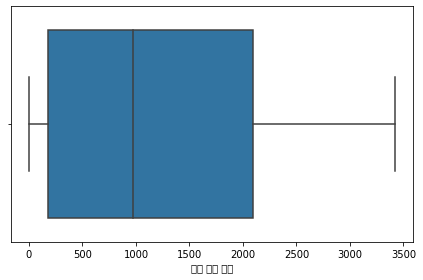

In [65]:
plt.subplot()
sns.boxplot(data['전체 출장 시간'])

plt.tight_layout()

In [66]:
print(data['전체 출장 시간'].describe())

count    4260.000000
mean     1211.544601
std      1071.767784
min         0.000000
25%       180.000000
50%       974.000000
75%      2094.500000
max      3420.000000
Name: 전체 출장 시간, dtype: float64


In [67]:
data = data.drop(data[data['전체 출장 시간'] < 180].index)

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3199 entries, 0 to 6120
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   이름         3199 non-null   object 
 1   연봉(€)      3199 non-null   float64
 2   시즌         3199 non-null   int64  
 3   포지션        3199 non-null   object 
 4   클럽팀        3199 non-null   object 
 5   전체 출장 시간   3199 non-null   float64
 6   전체 골       3199 non-null   float64
 7   전체 어시스트    3199 non-null   float64
 8   클린시트       3199 non-null   float64
 9   실점         3199 non-null   float64
 10  경고         3199 non-null   float64
 11  퇴장         3199 non-null   float64
 12  90분당 골 관여  3199 non-null   float64
 13  90분당 어시스트  3199 non-null   float64
 14  90분당 골     3199 non-null   float64
 15  90분당 실점    3199 non-null   float64
 16  카드/90분     3199 non-null   float64
 17  공격수 순위     3199 non-null   float64
 18  미드필더 순위    3199 non-null   float64
 19  수비수 순위     3199 non-null   float64
 20  득점 순위   

In [69]:
data.columns

Index(['이름', '연봉(€)', '시즌', '포지션', '클럽팀', '전체 출장 시간', '전체 골', '전체 어시스트',
       '클린시트', '실점', '경고', '퇴장', '90분당 골 관여', '90분당 어시스트', '90분당 골', '90분당 실점',
       '카드/90분', '공격수 순위', '미드필더 순위', '수비수 순위', '득점 순위', '나이'],
      dtype='object')

# 포지션별 데이터 생성

In [29]:
data = pd.read_csv(data_path + 'epl_data.csv', names=['이름', '연봉(€)', '시즌', '포지션', '클럽팀', '승점', '전체 출장 시간', '전체 골', '전체 어시스트',
       '클린시트', '실점', '경고', '퇴장', '90분당 골 관여', '90분당 어시스트', '90분당 골', '90분당 실점',
       '카드/90분', '공격수 순위', '미드필더 순위', '수비수 순위', '득점 순위', '나이'], header=0)
data

,이름,연봉(€),시즌,포지션,클럽팀,승점,전체 출장 시간,전체 골,전체 어시스트,클린시트,...,90분당 골 관여,90분당 어시스트,90분당 골,90분당 실점,카드/90분,공격수 순위,미드필더 순위,수비수 순위,득점 순위,나이
5373,Andy Carroll,4194589,2014,Forward,westhamunited,47,1026,5,1,5,...,0.53,0.09,0.44,0.96,0.18,19,150,-1,3,25
5374,Kevin Nolan,2996135,2014,Midfielder,westhamunited,47,1746,1,1,8,...,0.10,0.05,0.05,0.93,0.10,206,201,-1,11,32
5375,Stewart Downing,2996135,2014,Midfielder,westhamunited,47,3314,6,8,9,...,0.38,0.22,0.16,1.09,0.08,107,43,-1,2,30
5379,Matt Jarvis,2097295,2014,Midfielder,westhamunited,47,413,0,0,5,...,0.00,0.00,0.00,0.65,0.00,276,303,-1,14,28
5380,James Collins,2097295,2014,Defender,westhamunited,47,1879,0,0,7,...,0.00,0.00,0.00,0.96,0.34,390,415,35,25,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,Kieran Tierney,6591497,2022,Defender,arsenal,99,280,0,0,3,...,0.00,0.00,0.00,0.64,0.00,186,180,2,13,25
514,Aaron Ramsdale,3595362,2022,Goalkeeper,arsenal,99,720,0,0,3,...,0.00,0.00,0.00,1.00,0.00,183,177,25,19,24
517,Gabriel Magalh찾es,2996135,2022,Defender,arsenal,99,720,1,0,3,...,0.13,0.00,0.13,1.00,0.00,91,178,26,6,25
518,Albert Sambi Lokonga,2996135,2022,Forward,arsenal,99,195,0,0,3,...,0.00,0.00,0.00,1.38,0.00,-1,-1,-1,14,23


In [ ]:
GK = data[data['포지션'] == 'Goalkeeper']
DF = data[data['포지션'] == 'Defender']
MF = data[data['포지션'] == 'Midfielder']
FW = data[data['포지션'] == 'Forward']

In [ ]:
FW.head()

,이름,연봉(€),시즌,포지션,클럽팀,승점,전체 출장 시간,전체 골,전체 어시스트,클린시트,...,90분당 골 관여,90분당 어시스트,90분당 골,90분당 실점,카드/90분,공격수 순위,미드필더 순위,수비수 순위,득점 순위,나이
5373,Andy Carroll,4194589,2014,Forward,westhamunited,47,1026,5,1,5,...,0.53,0.09,0.44,0.96,0.18,19,150,-1,3,25
5392,Diafra Sakho,1198454,2014,Forward,westhamunited,47,1760,10,2,5,...,0.61,0.10,0.51,1.07,0.10,14,140,-1,1,25
5417,Victor Anichebe,1917527,2014,Forward,westbromwichalbion,44,1031,3,1,8,...,0.35,0.09,0.26,1.05,0.00,68,151,-1,4,26
5425,Saido Berahino,1498068,2014,Forward,westbromwichalbion,44,2930,14,1,16,...,0.46,0.03,0.43,1.32,0.06,21,237,-1,1,21
5443,Silvestre Varela,0,2014,Forward,westbromwichalbion,44,333,1,0,2,...,0.27,0.00,0.27,1.89,0.27,58,242,-1,11,29


# 선수 이름 오류 해결

In [74]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/캡스톤_4조/dataset/epl_data_sub.csv')
data

,Unnamed: 0,이름,연봉(€),시즌,포지션,클럽팀,전체 출장 시간,전체 골,전체 어시스트,클린시트,...,90분당 골 관여,90분당 어시스트,90분당 골,90분당 실점,카드/90분,공격수 순위,미드필더 순위,수비수 순위,득점 순위,나이
0,0,João Moutinho,5992270.0,2022,Midfielder,wolverhamptonwanderers,508.0,0.0,0.0,2.0,...,0.00,0.00,0.00,0.89,0.35,108.0,121.0,-1.0,9.0,36
1,1,Matheus Nunes,5093430.0,2022,Midfielder,wolverhamptonwanderers,507.0,0.0,1.0,2.0,...,0.18,0.18,0.00,1.07,0.18,101.0,49.0,-1.0,8.0,24
2,2,Nélson Semedo,4609439.0,2022,Defender,wolverhamptonwanderers,263.0,0.0,0.0,2.0,...,0.00,0.00,0.00,0.68,0.34,-1.0,-1.0,-1.0,4.0,29
3,3,Daniel Podence,3595362.0,2022,Forward,wolverhamptonwanderers,503.0,2.0,0.0,3.0,...,0.36,0.00,0.36,1.25,0.18,26.0,226.0,-1.0,1.0,27
4,6,Rúben Neves,2996135.0,2022,Midfielder,wolverhamptonwanderers,720.0,1.0,0.0,3.0,...,0.13,0.00,0.13,1.00,0.63,89.0,225.0,-1.0,2.0,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3194,6102,Kieran Gibbs,2756444.0,2014,Defender,arsenal,1658.0,0.0,3.0,7.0,...,0.16,0.16,0.00,1.09,0.16,336.0,73.0,56.0,26.0,25
3195,6103,Calum Chambers,2696522.0,2014,Defender,arsenal,1569.0,1.0,1.0,8.0,...,0.11,0.06,0.06,1.03,0.52,199.0,190.0,44.0,14.0,19
3196,6104,Francis Coquelin,1797681.0,2014,Midfielder,arsenal,1663.0,0.0,0.0,7.0,...,0.00,0.00,0.00,0.65,0.27,343.0,371.0,-1.0,21.0,23
3197,6110,Emiliano Martínez,599227.0,2014,Goalkeeper,arsenal,301.0,0.0,0.0,2.0,...,0.00,0.00,0.00,1.20,0.00,342.0,340.0,77.0,23.0,22


In [4]:
score_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/캡스톤_4조/dataset/epl_data.csv')
score_data = score_data[['Unnamed: 0', '승점']]

score_data

,Unnamed: 0,승점
0,5373,47
1,5374,47
2,5375,47
3,5379,47
4,5380,47
...,...,...
3194,509,99
3195,514,99
3196,517,99
3197,518,99


In [76]:
merge_data = pd.merge(data, score_data)
merge_data

del merge_data['Unnamed: 0']

In [ ]:
# # 포지션별 데이터 저장
# GK.to_csv('/content/drive/MyDrive/Colab Notebooks/캡스톤_4조/dataset/epl_GK_data.csv')
# DF.to_csv('/content/drive/MyDrive/Colab Notebooks/캡스톤_4조/dataset/epl_DF_data.csv')
# MF.to_csv('/content/drive/MyDrive/Colab Notebooks/캡스톤_4조/dataset/epl_MF_data.csv')
# FW.to_csv('/content/drive/MyDrive/Colab Notebooks/캡스톤_4조/dataset/epl_FW_data.csv')

In [77]:
merge_data.to_csv('/content/drive/MyDrive/Colab Notebooks/캡스톤_4조/dataset/epl_data.csv')

In [ ]:
# 데이터프레임을 csv로 저장
# data.to_csv('/content/drive/MyDrive/Colab Notebooks/캡스톤_4조/dataset/epl_data.csv')